<a href="https://colab.research.google.com/github/MALFAYEZ/malf64061/blob/main/Assignment_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Assignment2


## Loading and splitting dataset to train,validation,test sets



### Loading dataset from kaggle 

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"munerahalfayez","key":"7d75c682c03e04a709ee58c096092781"}'}

In [2]:

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:

!kaggle competitions download -c dogs-vs-cats

 98% 799M/812M [00:06<00:00, 164MB/s]
100% 812M/812M [00:07<00:00, 120MB/s]


In [4]:

!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

### Splitting the dataset to 1000 for training and 500 for validation and 500 for testing


In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

## Building the model

The model we are selected is Separable convolution layers. For selecting this model we assume that different channels are highly independent while the intermediate activations are highly correlated. 

Also there is a chance of overfitting so we are using both dropout layers at the end and also use data augmentation.

The optimizer we use is adam


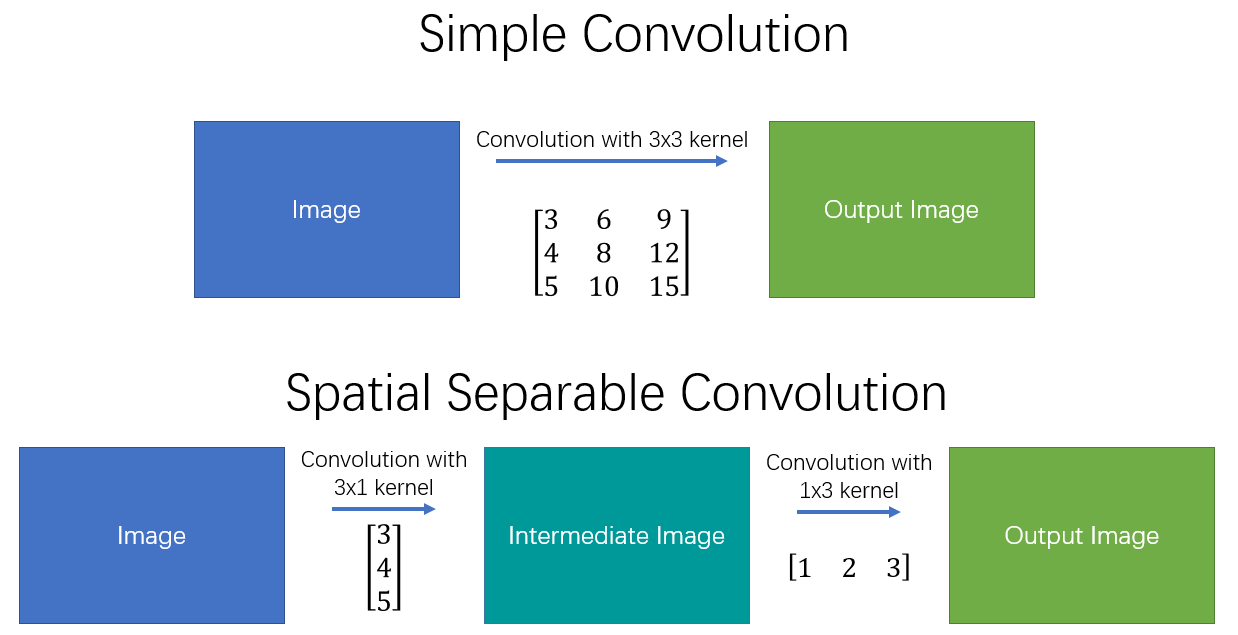

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.BatchNormalization()(x)
x = layers.SeparableConv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)
x = layers.SeparableConv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 3)      12        
 ormalization)                                                   
                                                                 
 separable_conv2d (Separable  (None, 178, 178, 128)    539       
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 128)      0         
 )                                                               
                                                             

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

## Testing the base model and then improving the model by changing the training size, Data augmentation and using pre-trained model

### 1000 for training and 500 for validation and 500 for testing

The batch size we took is 64.



In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=64)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=64)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=64)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


We have gpu available on colab. So we are changing the devie to GPU

In [11]:
import numpy as np
import tensorflow as tf
tf.device('/device:GPU:0')

random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [12]:

device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [13]:
batched_dataset = dataset.batch(32)
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))

**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [14]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (64, 180, 180, 3)
labels batch shape: (64,)


Using 10 epochs train the model.

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
32/32 [==============================] - 26s 424ms/step - loss: 1.2957 - accuracy: 0.5300 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 2/10
32/32 [==============================] - 14s 406ms/step - loss: 0.5943 - accuracy: 0.6795 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
32/32 [==============================] - 13s 397ms/step - loss: 0.4947 - accuracy: 0.7855 - val_loss: 0.6927 - val_accuracy: 0.5290
Epoch 4/10
32/32 [==============================] - 13s 400ms/step - loss: 0.3945 - accuracy: 0.8535 - val_loss: 0.6889 - val_accuracy: 0.6440
Epoch 5/10
32/32 [==============================] - 13s 402ms/step - loss: 0.2953 - accuracy: 0.8990 - val_loss: 0.6795 - val_accuracy: 0.6250
Epoch 6/10
32/32 [==============================] - 13s 402ms/step - loss: 0.2393 - accuracy: 0.9030 - val_loss: 0.6625 - val_accuracy: 0.6790
Epoch 7/10
32/32 [==============================] - 13s 403ms/step - loss: 0.1386 - accuracy: 0.9645 - val_loss: 0.6477 - val_accuracy: 0.6610

The validation accuracy and validation loss is dropping with each epoch which suggests the model isn't overfitting
With more epochs, the model would continue improving.

**Displaying curves of loss and accuracy during training**

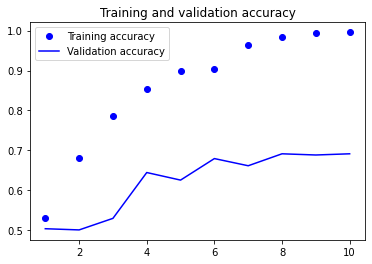

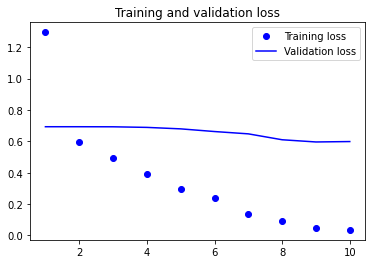

In [16]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [17]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 2s 93ms/step - loss: 0.6091 - accuracy: 0.6780
Test accuracy: 0.678


Model accuracy is right inline with validation accuracy of model
prediction is about 2/3 being predicted correctly
More epochs would increase model performance since it hasn't overfit yet
Ideally, with the right computing power, I'd set the number of epochs and graph validation accuracy to see if the model has overfit, then set the optimal number of epochs.

### Increasing the training dataset to 1500 per assignment instructions and re-training the model.

In [18]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.BatchNormalization()(x)
x = layers.SeparableConv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)
x = layers.SeparableConv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=64)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=64)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=64)


import numpy as np
import tensorflow as tf
# here we change the default device to gpu
tf.device('/device:GPU:0')

random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

batched_dataset = dataset.batch(64)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Found 3000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
(16,)
(16,)
(16,)
(64, 16)
(64, 16)
(64, 16)
(4, 4)
(4, 4)
(4, 4)
data batch shape: (64, 180, 180, 3)
labels batch shape: (64,)
Epoch 1/10
47/47 [==============================] - 22s 439ms/step - loss: 0.8100 - accuracy: 0.5973 - val_loss: 0.6931 - val_accuracy: 0.5170
Epoch 2/10
47/47 [==============================] - 20s 423ms/step - loss: 0.4740 - accuracy: 0.7803 - val_loss: 0.6926 - val_accuracy: 0.5100
Epoch 3/10
47/47 [==============================] - 20s 419ms/step - loss: 0.3953 - accuracy: 0.8243 - val_loss: 0.6893 - val_accuracy: 0.6355
Epoch 4/10
47/47 [==============================] - 20s 419ms/step - loss: 0.2543 - accuracy: 0.9153 - val_loss: 0.6692 - val_accuracy: 0.6865
Epoch 5/10
47/47 [==============================] - 20s 420ms/step - loss: 0.1504 - accuracy: 0.9570 - val_loss: 0.6036 - val_accuracy: 0.8010
Epoch 6/10
47/47 [================

**Displaying curves of loss and accuracy during training**

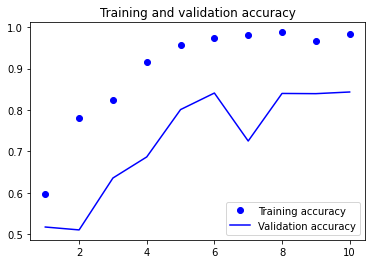

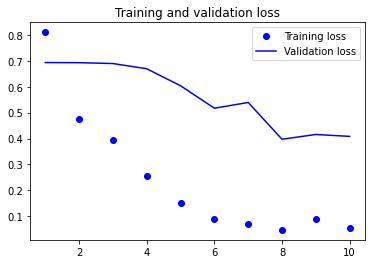

In [20]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [21]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 82ms/step - loss: 0.5891 - accuracy: 0.6945
Test accuracy: 0.695


Increasing the size of the training sample drastically increased validation accuracy from 68% to 84% and reduced validation loss withthe same number of epochs, however,  accuracy on the test data set only increased from 64% to 69%.

### Using a pre-trained convolution model and using data augmentation as per assignment instructions

In [22]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Printing the list of trainable weights before and after freezing**
conv_base.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


**Adding a data augmentation stage and a classifier to the convolutional base**

In [23]:
# creating the data augmetation object and passing to the model

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

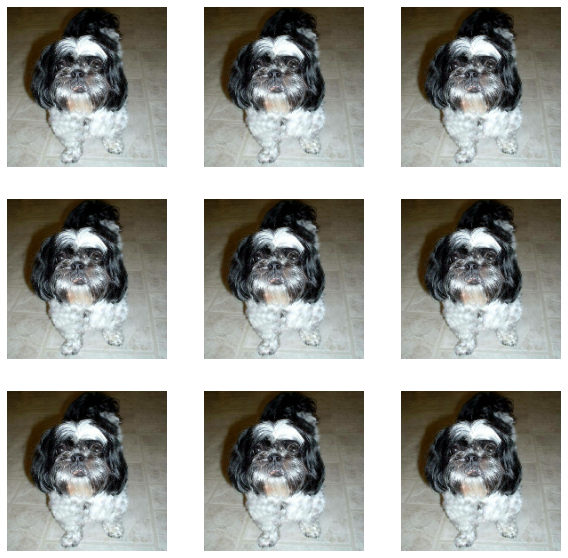

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]


# Limiting the model to 10 epochs to compare it with the model trained from scratch.

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
47/47 [==============================] - 29s 508ms/step - loss: 26.4079 - accuracy: 0.8960 - val_loss: 7.2429 - val_accuracy: 0.9510
Epoch 2/10
47/47 [==============================] - 19s 405ms/step - loss: 8.3025 - accuracy: 0.9403 - val_loss: 5.1299 - val_accuracy: 0.9715
Epoch 3/10
47/47 [==============================] - 19s 403ms/step - loss: 4.7026 - accuracy: 0.9577 - val_loss: 2.0898 - val_accuracy: 0.9820
Epoch 4/10
47/47 [==============================] - 19s 394ms/step - loss: 4.1028 - accuracy: 0.9633 - val_loss: 2.2065 - val_accuracy: 0.9800
Epoch 5/10
47/47 [==============================] - 19s 398ms/step - loss: 3.5600 - accuracy: 0.9653 - val_loss: 1.8913 - val_accuracy: 0.9835
Epoch 6/10
47/47 [==============================] - 19s 400ms/step - loss: 3.4109 - accuracy: 0.9650 - val_loss: 1.0816 - val_accuracy: 0.9885
Epoch 7/10
47/47 [==============================] - 19s 396ms/step - loss: 2.8154 - accuracy: 0.9730 - val_loss: 5.2604 - val_accuracy: 0.962

**Displaying curves of loss and accuracy during training**

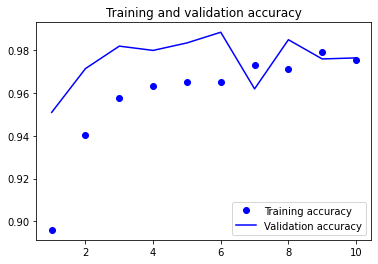

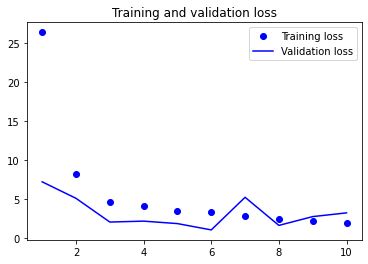

In [26]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Here we can clearly see the changes in validation accuracy from the previous model. It's almost 0.98 which is close to testing accuracy of 0.975. So we can conclude that it's not over fitting.**

**Evaluating the model on the test set**

In [27]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 8s 221ms/step - loss: 2.2954 - accuracy: 0.9805
Test accuracy: 0.980


### In order to fine tune a pre-trained model, we have to adjust the learning rate of the model.  The learning rate has an impact on finding local minimums and maximums.  large adjustments to the learning rate will have drastic impacts on the model.  

In [28]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [29]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
47/47 [==============================] - 22s 437ms/step - loss: 1.7724 - accuracy: 0.9787 - val_loss: 0.9857 - val_accuracy: 0.9870
Epoch 2/10
47/47 [==============================] - 21s 430ms/step - loss: 0.6287 - accuracy: 0.9833 - val_loss: 1.0613 - val_accuracy: 0.9840
Epoch 3/10
47/47 [==============================] - 21s 429ms/step - loss: 0.5922 - accuracy: 0.9853 - val_loss: 0.9265 - val_accuracy: 0.9865
Epoch 4/10
47/47 [==============================] - 21s 433ms/step - loss: 0.5775 - accuracy: 0.9877 - val_loss: 0.9348 - val_accuracy: 0.9865
Epoch 5/10
47/47 [==============================] - 21s 428ms/step - loss: 0.7863 - accuracy: 0.9837 - val_loss: 0.8037 - val_accuracy: 0.9895
Epoch 6/10
47/47 [==============================] - 20s 427ms/step - loss: 0.3656 - accuracy: 0.9910 - val_loss: 1.0479 - val_accuracy: 0.9830
Epoch 7/10
47/47 [==============================] - 21s 434ms/step - loss: 0.5750 - accuracy: 0.9853 - val_loss: 0.9494 - val_accuracy: 0.9845

**Displaying curves of loss and accuracy during training**

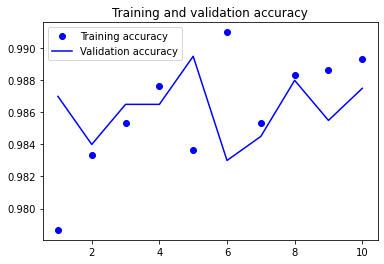

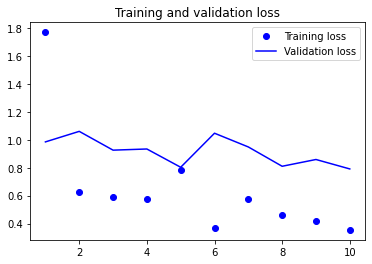

In [30]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [31]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 8s 225ms/step - loss: 1.7314 - accuracy: 0.9765
Test accuracy: 0.976


Here we can see there is a small change from the last model on accuracy and testing accuracy.